In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('../data/master_table.csv')
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

print("Data loaded. Rows:", len(df))

print()

# Identify the top seller
top_product = df.groupby('product_id')['price'].sum().sort_values(ascending=False).index[0]

print(f"The top product ID: {top_product}")

# Filter the dataset to keep only this product
df_products = df[df['product_id'] == top_product].copy()

print(f"Sales record: {len(df_products)}")
display(df_products.head(3))

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing plotly failed. Interactive plots will not work.


Data loaded. Rows: 108630

The top product ID: bb50f2e236e5eea0100680137654686c
Sales record: 194


,order_id,product_id,category,price,freight_value,order_purchase_timestamp,actual_lead_time_days,delivery_performance
305,ed91235fc08276eed0470b26a6dbd4a3,bb50f2e236e5eea0100680137654686c,health_beauty,325.0,38.96,2018-03-09 14:58:05,20.0,6.0
1802,6596197a74edd396e3d34c53eff4ad6f,bb50f2e236e5eea0100680137654686c,health_beauty,325.0,13.77,2018-02-07 20:18:57,7.0,17.0
2176,6e57e23ecac1ae881286657694444267,bb50f2e236e5eea0100680137654686c,health_beauty,330.0,20.41,2018-08-09 17:36:47,7.0,19.0


First 5 week:


,ds,y
0,2017-08-20,2
1,2017-08-27,3
2,2017-09-03,1
3,2017-09-10,2
4,2017-09-17,1


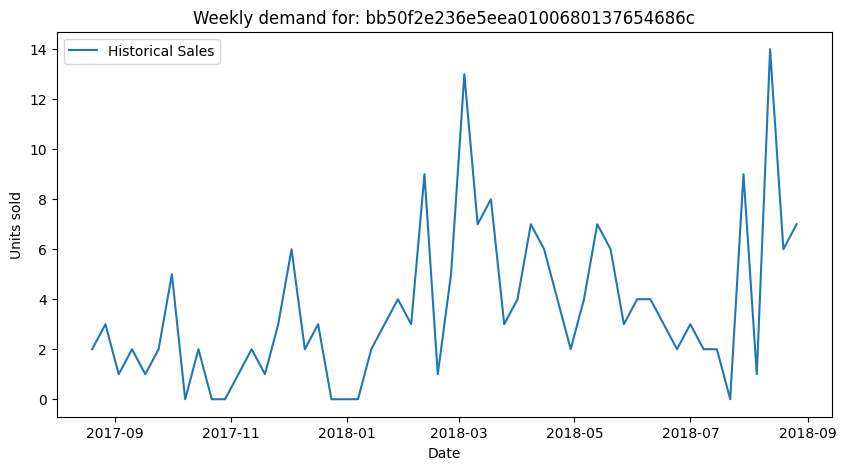

In [2]:
# Aggregate data by week
# Set index for date so can 'resample'
df_products.set_index('order_purchase_timestamp', inplace=True)

# Number of orders per week
weekly_demand = df_products.resample('W').size().reset_index()
weekly_demand.columns = ['ds', 'y']

print("First 5 week:")
display(weekly_demand.head())

# Before forecast
plt.figure(figsize=(10, 5))
plt.plot(weekly_demand['ds'], weekly_demand['y'], label='Historical Sales')
plt.title(f'Weekly demand for: {top_product}')
plt.xlabel('Date')
plt.ylabel('Units sold')
plt.legend()
plt.show()

In [3]:
# Train the model
# interval_width=0.95 means we want a 95% confidence interval (Crucial for Safety Stock later)
m = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False)

# Fit the model to historical data
m.fit(weekly_demand)

print('Model trained successfully!')

02:39:12 - cmdstanpy - INFO - Chain [1] start processing


02:39:13 - cmdstanpy - INFO - Chain [1] done processing


Model trained successfully!


Forecast generated. Next 5 weeks:


,ds,yhat,yhat_lower,yhat_upper
54,2018-09-02,6.384901,2.537721,10.420562
55,2018-09-09,6.337642,2.065776,10.160993
56,2018-09-16,6.810014,2.782715,10.759856
57,2018-09-23,7.404463,3.524966,11.355635
58,2018-09-30,7.687880,3.346530,11.599379
59,2018-10-07,7.351208,3.536767,11.438538
60,2018-10-14,6.436750,2.742131,10.310813
61,2018-10-21,5.438778,1.543628,9.258264
62,2018-10-28,5.004703,1.143130,8.838989
63,2018-11-04,5.410533,1.241312,9.407027


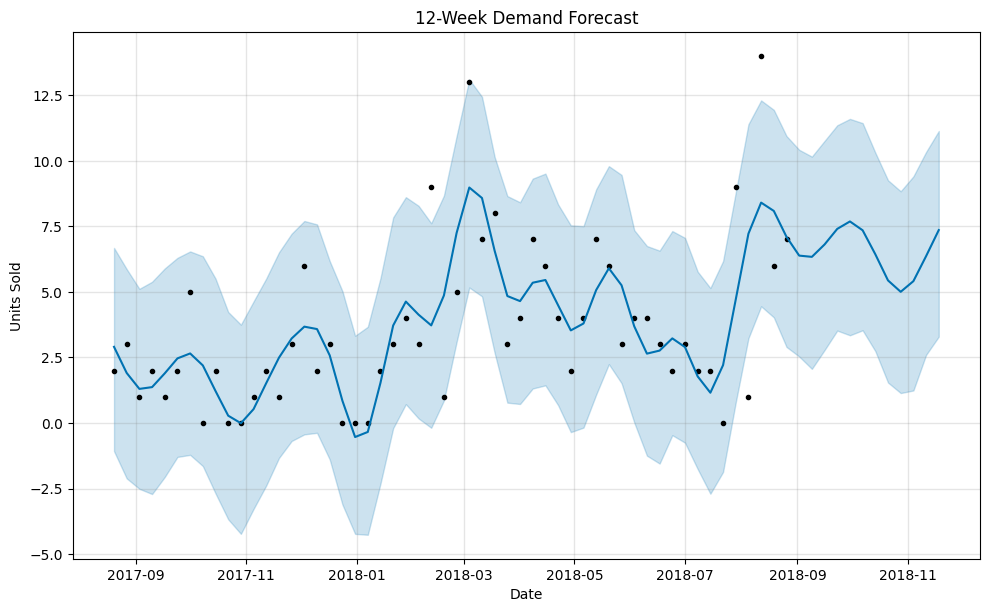

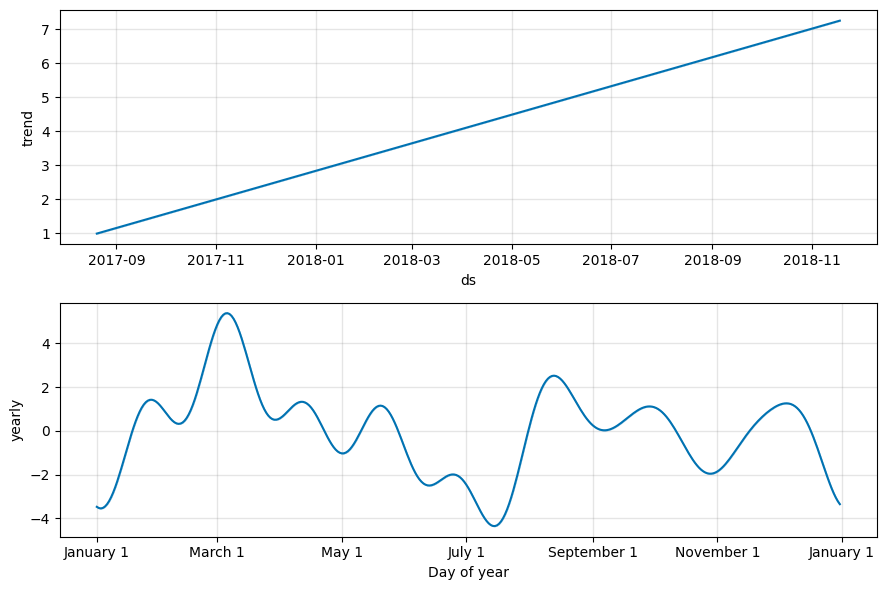

In [4]:
# Make prediction
future = m.make_future_dataframe(periods=12, freq='W')

# Predict
forecast = m.predict(future)

print("Forecast generated. Next 5 weeks:")
cols_to_keep = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
display(forecast[cols_to_keep].tail(12))

# Visualize the forecast
fig1 = m.plot(forecast)
fig1.savefig('../results/figures/forecast_plot.png', bbox_inches='tight')
plt.title('12-Week Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

fig2 = m.plot_components(forecast)

In [5]:
# Save the forecast to CSV so Phase 4 can read it
forecast.to_csv('../data/forecast_output.csv', index=False)
print("Forecast saved.")

Forecast saved.
